In [32]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention,CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [33]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [34]:
dnf300 = pd.read_json('evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V3.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [35]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

35

In [36]:
titles = sorted(dnf300.headline.unique())
len(titles)

300

In [37]:
test_titles = sorted(dnf_eval.headline.unique())

In [38]:
titles = sorted(dnf300.headline.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))


In [39]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [40]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252] [153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 

(203, 50, 50)

In [ ]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [ ]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
            except Exception as ex:
                print(ex)
                print(idx)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [ ]:
tdg = datagen_dnf(train_batchsize,dnf300,mode='train')
vdg = datagen_dnf(val_batchsize,dnf300,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf300,mode='test')

In [ ]:
x,y = next(test_dg)

In [14]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

In [ ]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [16]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf300_sa_sent_hd_vector.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf300_sa_sent_hd_vector/{0}'.format(dt.timestamp()),write_graph=True)

In [17]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 13s 3s/step - loss: 1.2944 - val_loss: 0.2150
Epoch 2/2000
4/4 [==============================] - 0s 54ms/step - loss: 1.2715 - val_loss: 0.1970
Epoch 3/2000
4/4 [==============================] - 0s 56ms/step - loss: 1.2647 - val_loss: 0.1948
Epoch 4/2000
4/4 [==============================] - 2s 431ms/step - loss: 1.2787 - val_loss: 0.1833
Epoch 5/2000
4/4 [==============================] - 3s 680ms/step - loss: 1.2404 - val_loss: 0.1787
Epoch 6/2000
4/4 [==============================] - 3s 704ms/step - loss: 1.2394 - val_loss: 0.1745
Epoch 7/2000
4/4 [==============================] - 2s 515ms/step - loss: 1.2343 - val_loss: 0.1653
Epoch 8/2000
4/4 [==============================] - 2s 568ms/step - loss: 1.2214 - val_loss: 0.1612
Epoch 9/2000
4/4 [==============================] - 2s 598ms/step - loss: 1.2206 - val_loss: 0.1590
Epoch 10/2000
4/4 [==============================] - 3s 665ms/step - loss: 1.2088 - val_loss: 0.1539
Epo

4/4 [==============================] - 2s 605ms/step - loss: 0.4685 - val_loss: 0.0224
Epoch 163/2000
4/4 [==============================] - 3s 716ms/step - loss: 0.4707 - val_loss: 0.0191
Epoch 164/2000
4/4 [==============================] - 3s 635ms/step - loss: 0.4760 - val_loss: 0.0218
Epoch 165/2000
4/4 [==============================] - 2s 554ms/step - loss: 0.4603 - val_loss: 0.0197
Epoch 166/2000
4/4 [==============================] - 3s 642ms/step - loss: 0.4738 - val_loss: 0.0201
Epoch 167/2000
4/4 [==============================] - 3s 746ms/step - loss: 0.4593 - val_loss: 0.0194
Epoch 168/2000
4/4 [==============================] - 3s 652ms/step - loss: 0.4659 - val_loss: 0.0194
Epoch 169/2000
4/4 [==============================] - 3s 671ms/step - loss: 0.4633 - val_loss: 0.0176
Epoch 170/2000
4/4 [==============================] - 2s 623ms/step - loss: 0.4714 - val_loss: 0.0184
Epoch 171/2000
4/4 [==============================] - 3s 679ms/step - loss: 0.4541 - val_loss: 0.

4/4 [==============================] - 3s 661ms/step - loss: 0.2306 - val_loss: 0.0105
Epoch 323/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.2402 - val_loss: 0.0114
Epoch 324/2000
4/4 [==============================] - 3s 683ms/step - loss: 0.2267 - val_loss: 0.0115
Epoch 325/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.2416 - val_loss: 0.0115
Epoch 326/2000
4/4 [==============================] - 3s 799ms/step - loss: 0.2170 - val_loss: 0.0115
Epoch 327/2000
4/4 [==============================] - 3s 711ms/step - loss: 0.2289 - val_loss: 0.0127
Epoch 328/2000
4/4 [==============================] - 3s 685ms/step - loss: 0.2225 - val_loss: 0.0126
Epoch 329/2000
4/4 [==============================] - 3s 631ms/step - loss: 0.2226 - val_loss: 0.0124
Epoch 330/2000
4/4 [==============================] - 3s 676ms/step - loss: 0.2070 - val_loss: 0.0106
Epoch 331/2000
4/4 [==============================] - 3s 694ms/step - loss: 0.2233 - val_loss: 0.

4/4 [==============================] - 3s 703ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 483/2000
4/4 [==============================] - 3s 627ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 484/2000
4/4 [==============================] - 3s 627ms/step - loss: 0.0109 - val_loss: 0.0134
Epoch 485/2000
4/4 [==============================] - 2s 595ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 486/2000
4/4 [==============================] - 3s 683ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 487/2000
4/4 [==============================] - 3s 689ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 488/2000
4/4 [==============================] - 3s 704ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 489/2000
4/4 [==============================] - 3s 626ms/step - loss: 0.0112 - val_loss: 0.0134
Epoch 490/2000
4/4 [==============================] - 3s 629ms/step - loss: 0.0104 - val_loss: 0.0112
Epoch 491/2000
4/4 [==============================] - 3s 658ms/step - loss: 0.0107 - val_loss: 0.

4/4 [==============================] - 3s 698ms/step - loss: 0.0097 - val_loss: 0.0107
Epoch 643/2000
4/4 [==============================] - 3s 765ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 644/2000
4/4 [==============================] - 3s 651ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 645/2000
4/4 [==============================] - 3s 772ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 646/2000
4/4 [==============================] - 3s 728ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 647/2000
4/4 [==============================] - 3s 802ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 648/2000
4/4 [==============================] - 3s 741ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 649/2000
4/4 [==============================] - 3s 747ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 650/2000
4/4 [==============================] - 3s 722ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 651/2000
4/4 [==============================] - 3s 626ms/step - loss: 0.0099 - val_loss: 0.

4/4 [==============================] - 3s 656ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 803/2000
4/4 [==============================] - 2s 625ms/step - loss: 0.0108 - val_loss: 0.0124
Epoch 804/2000
4/4 [==============================] - 3s 726ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 805/2000
4/4 [==============================] - 2s 564ms/step - loss: 0.0099 - val_loss: 0.0122
Epoch 806/2000
4/4 [==============================] - 2s 612ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 807/2000
4/4 [==============================] - 2s 577ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 808/2000
4/4 [==============================] - 3s 658ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 809/2000
4/4 [==============================] - 3s 628ms/step - loss: 0.0110 - val_loss: 0.0097
Epoch 810/2000
4/4 [==============================] - 3s 688ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 811/2000
4/4 [==============================] - 2s 608ms/step - loss: 0.0104 - val_loss: 0.

4/4 [==============================] - 3s 684ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 963/2000
4/4 [==============================] - 3s 720ms/step - loss: 0.0109 - val_loss: 0.0121
Epoch 964/2000
4/4 [==============================] - 3s 775ms/step - loss: 0.0100 - val_loss: 0.0113
Epoch 965/2000
4/4 [==============================] - 3s 737ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 966/2000
4/4 [==============================] - 3s 713ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 967/2000
4/4 [==============================] - 3s 748ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 968/2000
4/4 [==============================] - 3s 713ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 969/2000
4/4 [==============================] - 3s 718ms/step - loss: 0.0110 - val_loss: 0.0094
Epoch 970/2000
4/4 [==============================] - 3s 641ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 971/2000
4/4 [==============================] - 3s 714ms/step - loss: 0.0110 - val_loss: 0.

4/4 [==============================] - 3s 740ms/step - loss: 0.0102 - val_loss: 0.0124
Epoch 1043/2000
4/4 [==============================] - 3s 659ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 1044/2000
4/4 [==============================] - 3s 673ms/step - loss: 0.0115 - val_loss: 0.0123
Epoch 1045/2000
4/4 [==============================] - 3s 675ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 1046/2000
4/4 [==============================] - 3s 707ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 1047/2000
4/4 [==============================] - 3s 763ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 1048/2000
4/4 [==============================] - 2s 610ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 1049/2000
4/4 [==============================] - 3s 652ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 1050/2000
4/4 [==============================] - 3s 697ms/step - loss: 0.0104 - val_loss: 0.0115
Epoch 1051/2000
4/4 [==============================] - 3s 726ms/step - loss: 0.0100 - val

4/4 [==============================] - 3s 779ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 1201/2000
4/4 [==============================] - 3s 703ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 1202/2000
4/4 [==============================] - 3s 743ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 1203/2000
4/4 [==============================] - 3s 768ms/step - loss: 0.0125 - val_loss: 0.0111
Epoch 1204/2000
4/4 [==============================] - 3s 733ms/step - loss: 0.0108 - val_loss: 0.0118
Epoch 1205/2000
4/4 [==============================] - 3s 674ms/step - loss: 0.0100 - val_loss: 0.0112
Epoch 1206/2000
4/4 [==============================] - 3s 631ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 1207/2000
4/4 [==============================] - 3s 642ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 1208/2000
4/4 [==============================] - 3s 672ms/step - loss: 0.0112 - val_loss: 0.0127
Epoch 1209/2000
4/4 [==============================] - 3s 640ms/step - loss: 0.0102 - val

4/4 [==============================] - 3s 685ms/step - loss: 0.0106 - val_loss: 0.0130
Epoch 1359/2000
4/4 [==============================] - 2s 594ms/step - loss: 0.0103 - val_loss: 0.0130
Epoch 1360/2000
4/4 [==============================] - 2s 607ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 1361/2000
4/4 [==============================] - 3s 632ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 1362/2000
4/4 [==============================] - 3s 723ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 1363/2000
4/4 [==============================] - 3s 692ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 1364/2000
4/4 [==============================] - 3s 748ms/step - loss: 0.0108 - val_loss: 0.0118
Epoch 1365/2000
4/4 [==============================] - 3s 727ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 1366/2000
4/4 [==============================] - 3s 650ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 1367/2000
4/4 [==============================] - 3s 633ms/step - loss: 0.0105 - val

4/4 [==============================] - 3s 771ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 1517/2000
4/4 [==============================] - 3s 643ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 1518/2000
4/4 [==============================] - 3s 685ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 1519/2000
4/4 [==============================] - 3s 793ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 1520/2000
4/4 [==============================] - 3s 691ms/step - loss: 0.0109 - val_loss: 0.0118
Epoch 1521/2000
4/4 [==============================] - 3s 640ms/step - loss: 0.0107 - val_loss: 0.0117
Epoch 1522/2000
4/4 [==============================] - 3s 627ms/step - loss: 0.0109 - val_loss: 0.0116
Epoch 1523/2000
4/4 [==============================] - 3s 717ms/step - loss: 0.0108 - val_loss: 0.0125
Epoch 1524/2000
4/4 [==============================] - 2s 582ms/step - loss: 0.0101 - val_loss: 0.0126
Epoch 1525/2000
4/4 [==============================] - 2s 595ms/step - loss: 0.0105 - val

4/4 [==============================] - 3s 658ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 1675/2000
4/4 [==============================] - 3s 693ms/step - loss: 0.0104 - val_loss: 0.0113
Epoch 1676/2000
4/4 [==============================] - 3s 719ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 1677/2000
4/4 [==============================] - 3s 721ms/step - loss: 0.0111 - val_loss: 0.0118
Epoch 1678/2000
4/4 [==============================] - 3s 754ms/step - loss: 0.0106 - val_loss: 0.0126
Epoch 1679/2000
4/4 [==============================] - 3s 726ms/step - loss: 0.0103 - val_loss: 0.0119
Epoch 1680/2000
4/4 [==============================] - 3s 699ms/step - loss: 0.0102 - val_loss: 0.0113
Epoch 1681/2000
4/4 [==============================] - 3s 693ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 1682/2000
4/4 [==============================] - 3s 830ms/step - loss: 0.0113 - val_loss: 0.0122
Epoch 1683/2000
4/4 [==============================] - 3s 701ms/step - loss: 0.0105 - val

4/4 [==============================] - 2s 558ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 1833/2000
4/4 [==============================] - 3s 711ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 1834/2000
4/4 [==============================] - 3s 683ms/step - loss: 0.0103 - val_loss: 0.0116
Epoch 1835/2000
4/4 [==============================] - 3s 663ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 1836/2000
4/4 [==============================] - 3s 663ms/step - loss: 0.0113 - val_loss: 0.0085
Epoch 1837/2000
4/4 [==============================] - 3s 660ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 1838/2000
4/4 [==============================] - 3s 788ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 1839/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.0113 - val_loss: 0.0124
Epoch 1840/2000
4/4 [==============================] - 3s 652ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 1841/2000
4/4 [==============================] - 3s 674ms/step - loss: 0.0102 - val

4/4 [==============================] - 2s 409ms/step - loss: 0.0105 - val_loss: 0.0118
Epoch 1991/2000
4/4 [==============================] - 2s 426ms/step - loss: 0.0105 - val_loss: 0.0107
Epoch 1992/2000
4/4 [==============================] - 2s 411ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 1993/2000
4/4 [==============================] - 2s 415ms/step - loss: 0.0111 - val_loss: 0.0120
Epoch 1994/2000
4/4 [==============================] - 2s 414ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 1995/2000
4/4 [==============================] - 2s 396ms/step - loss: 0.0101 - val_loss: 0.0128
Epoch 1996/2000
4/4 [==============================] - 2s 425ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 1997/2000
4/4 [==============================] - 2s 418ms/step - loss: 0.0112 - val_loss: 0.0120
Epoch 1998/2000
4/4 [==============================] - 2s 422ms/step - loss: 0.0102 - val_loss: 0.0127
Epoch 1999/2000
4/4 [==============================] - 2s 415ms/step - loss: 0.0106 - val

In [18]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [19]:
# df_res = pd.DataFrame(hist.history)

In [20]:
# df_res[['loss','val_loss']].plot()

In [21]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [ ]:
model.load_weights('weights/dnf300_sa_sent_hd_vector.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

In [ ]:
x,y = next(test_dg)
pred = model.predict(x)

In [ ]:
for i in range(len(x['headline'])):
    
    print(i,':',x['headline'][i])

In [20]:
test_idx = 3
display(x['headline'][test_idx])

"hillary clinton in 2013: 'i would like to see people like donald trump run for office"

In [21]:
x['sentences'][test_idx]


['Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought.',
 'In a speech made public by Wikileaks – which released an email from Hillary for America Research Director Tony Caark containing three attached speeches given at a private Goldman Sachs events – Clinton spoke and took audience questions at the “Builders and Innovators Summit” hosted by Goldman Sachs on October 29, 2013.',
 'Answering a question about businessmen in politics, Clinton said that they are “most often the people that look over the horizon,” and therefore share a vision that many politicians of today lack. “',
 'And that’s a very good question and thank you for asking it.',
 'Yes, I would love to see more businessmen go into politics because I believe they would bring in an entirely different mindset and strat

# Model Test

In [22]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 35, 300)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 16)       14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 16)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 32)       1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [23]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [24]:
# g1,g2,g3,g4

In [25]:
b = b1+b2+b3+b4

In [26]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([11, 10,  9,  5,  8])

In [27]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

12


-0.49168015

In [31]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

"hillary clinton in 2013: 'i would like to see people like donald trump run for office"

['Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought.',
 'And it’s telling me that Donald Trump would be very successful if he were to venture into politics in the future.” Asked to elaborate on her statement, the former Secretary of State argued that she thinks that businessmen “can’t be bought” and that they’re “very honest.” “And I think that goes especially for Donald Trump, whose successful projects and business ventures have made him synonymous with big business and, more importantly, creating thousands of jobs.',
 'I also think he understands the philanthropic and charitable side of things quite well, which is a crucial skill for any politician,” she praised her current counter-candidate.']

In [29]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

11 : I also think he understands the philanthropic and charitable side of things quite well, which is a crucial skill for any politician,” she praised her current counter-candidate.
10 : And I think that goes especially for Donald Trump, whose successful projects and business ventures have made him synonymous with big business and, more importantly, creating thousands of jobs.
9 : Asked to elaborate on her statement, the former Secretary of State argued that she thinks that businessmen “can’t be bought” and that they’re “very honest.” “
5 : And then she just had to go on. “
8 : And it’s telling me that Donald Trump would be very successful if he were to venture into politics in the future.”


In [62]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

6


-3.6989129

In [63]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

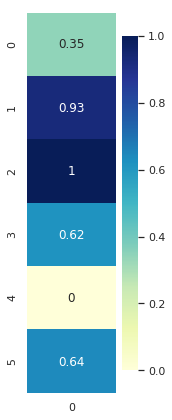

In [64]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [65]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 35, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 16)            14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 32)            1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 32)            128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 35, 32), (35, 35) 2377      
Total para

In [66]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [71]:
sg1,sg2, sg3, sg4

(array([0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461,
        0.00227461, 0.00227461, 0.00227461, 0.00227461, 0.00227461],
       dtype=float32),
 array([-0.00252605, -0.00252605, -0.00252605, -0.00252605, -0.00252605,
        -0.00252605, -0.00252605, -0.00252605, -0.00252605, -0.00252605,
        -0.00252605, -0.00252605, -0.00252605, -0.00252605, -0.00252605,
        -0.00252605, -0.00252605, -0.00252605, -0.00252605, -0.00252605,
    

In [67]:
sb = sb1[test_idx]+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(6, 6)

In [68]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

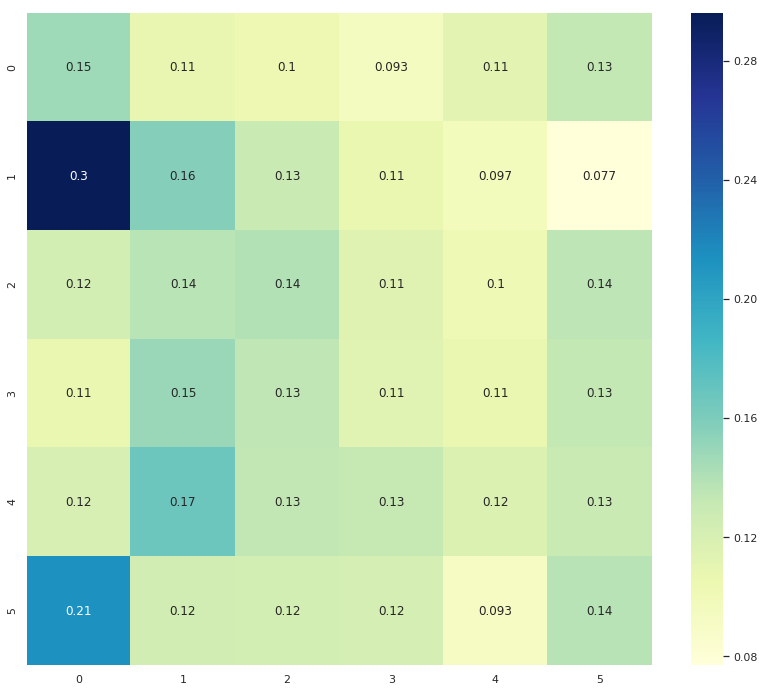

In [69]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [42]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"This US has publicly threatened ‘retaliatory’ hacks against Russia for weeks now, based on allegations that Russia may have been involved in certain hacks related to Democratic presidential candidate Hillary Clinton."
1,Russia denied involvement and the US government has been unable to produce any concrete evidence of Russian involvement.
2,Vice President Joe Biden went so far as to confirm the US had informed Vladimir Putin that the US would conduct revenge attacks “at the time of our choosing.”
3,"The time may ultimately be America’s election day, according to officials familiar with the situation."
4,"NBC News has reported seeing top secret documents from these officials detailing potential US plans to launch military cyber attacks against Russia’s civilian infrastructure, with the documents claiming advanced US cyber weapons were prepared to take down Russia’s entire electricity grid, all telecommunications networks, and the Kremlin’s own command systems."
5,The reports are emerging in the context of US officials speculating that Russia might launch cyber attacks against the US during the election to try to disrupt it.
6,"Since they offered no evidence for this either, it raises concerns that the US is simply setting up a pretext for timing its own attacks around them."
7,"That officials are trying to assure the media that such huge attacks would only be launched in retaliation offers little comfort, given the administration’s willingness to claim anything and everything remotely election-related and embarrassing to the Clinton campaign as a Russian plot."
8,"Such massive US attacks on Russian infrastructure, regardless of the pretext, would likely be seen as an act of war."
9,"The US has made clear in the past they would regard cyber attacks of a large enough scale as equivalent to conventional military attacks, and given the scale that it being discussed it’s hard to imagine Russia would not react similarly."
